# Bayesian optimization on a small neural network

### Imports

In [1]:
import torch
from torch import nn, optim

import sklearn
import sklearn.model_selection as skm

from bayes_opt import BayesianOptimization

import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt

from tqdm import tqdm

rcParams['figure.figsize'] = 12, 8

from scipy.stats import ttest_ind

from helpers_NN import *

### Data

In [3]:
# Import the titanic survival data

titanic = pd.read_excel('data/titanic.xls')
titanic_features = ['sex', 'age', 'sibsp', 'parch', 'fare']

In [4]:
# Keep 3 of the features to reduce the size of the neural network

X = pd.get_dummies(titanic[titanic_features])
X = X.fillna(X.mean())
X = X[['age', 'fare', 'sex_male']]
X.head(5)

,age,fare,sex_male
0,29.0000,211.3375,0
1,0.9167,151.5500,1
2,2.0000,151.5500,0
3,30.0000,151.5500,1
4,25.0000,151.5500,0


In [5]:
# Expected output

y = titanic['survived']
y.head(5)

0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: int64

### Functions

In [6]:
# Function outputing the loss to maximize during the steps of bayesian optimization

def net_classifier(w100, w101, w102, w110, w111, w112, w120, w121, w122, b10, b11, b12, w20, w21, w22, b2):

    # Initialize a neural network
    net = Net(X_train.shape[1])
    
    # Set the weights and the biases of the net
    weights1 = torch.nn.Parameter(torch.Tensor(np.array([[w100, w101, w102], [w110, w111, w112], [w120, w121, w122]])))
    bias1 = torch.nn.Parameter(torch.Tensor(np.array([b10, b11, b12])))
    weights2 = torch.nn.Parameter(torch.Tensor(np.array([[w20, w21, w22]])))
    bias2 = torch.nn.Parameter(torch.Tensor(np.array([b2])))
    
    net.fc1.weight = weights1
    net.fc1.bias = bias1
    net.fc2.weight = weights2
    net.fc2.bias = bias2

    # Criterion is Binary Cross-Entropy Loss
    criterion = nn.BCELoss()

    # Get the predicted outputs through the neural net
    y_pred = torch.squeeze(net(X_train)).ge(.5).view(-1)
    bin_pred = []
    for element in y_pred.numpy():
        if element:
            bin_pred.append(1)
        else:
            bin_pred.append(0)
    y_pred = torch.Tensor(np.array(bin_pred)).type(torch.float)

    # Calculate the loss with respect to the expected outputs
    loss = criterion(y_pred, y_train)

    # Return the negative loss to allow for maximization 
    return (-1)*loss

### Parameters

In [7]:
# Number of steps of gradient descent
n_steps= 1000

# Number of instances 
n_inst = 100

### Gradient descent only

In [8]:
grad_test_loss = []
grad_train_loss = []

pbar = tqdm(total=n_inst)

for i in range(n_inst):
    torch.manual_seed(i)
    # Initialize net, criterion and optimizer
    net = Net(X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001)

    # Separate train and test set
    X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.20)
    X_train = torch.from_numpy(X_train.to_numpy()).float()
    y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
    X_test = torch.from_numpy(X_test.to_numpy()).float()
    y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

    # Gradient descent
    train_loss, test_loss = grad_descent(n_steps, net, optimizer, criterion, X_train, y_train, X_test, y_test)

    grad_train_loss.append(train_loss)
    grad_test_loss.append(test_loss)

    pbar.update(1)

pbar.close()

100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


### Bayesian optimization

In [9]:
bo_train_loss = []
bo_test_loss = []

# Bayesian optimization will search in [-bound, +bound]
bound = 1/np.sqrt(3)


pbar = tqdm(total=n_inst)

for i in range(n_inst):

    # Separate train and test set
    X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.20)
    X_train = torch.from_numpy(X_train.to_numpy()).float()
    y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
    X_test = torch.from_numpy(X_test.to_numpy()).float()
    y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

    # Initialize an instance of Bayesian Optimization to optimize the weights and biases of the net
    netBO = BayesianOptimization(net_classifier, {  'w100': (-bound, bound),
                                                    'w101': (-bound, bound),
                                                    'w102': (-bound, bound),
                                                    'w110': (-bound, bound),
                                                    'w111': (-bound, bound),
                                                    'w112': (-bound, bound),
                                                    'w120': (-bound, bound),
                                                    'w121': (-bound, bound),
                                                    'w122': (-bound, bound),
                                                    'b10': (-bound, bound),
                                                    'b11': (-bound, bound),
                                                    'b12': (-bound, bound),
                                                    'w20': (-bound, bound),
                                                    'w21': (-bound, bound),
                                                    'w22': (-bound, bound),
                                                    'b2': (-bound, bound)},
                                                    verbose= 0,
                                                    random_state=i)
    
    # Maximize the negative loss
    netBO.maximize(n_iter=10, init_points=5)

    # Get the weights and biases that got the best result
    params = netBO.max['params']
    
    # Initialize a neural net
    net = Net(X.shape[1])
    
    # Initialize the weights with the best result from BO
    weights1 = torch.nn.Parameter(torch.Tensor(np.array([[params['w100'], params['w101'], params['w102']], [params['w110'], params['w111'], params['w112']], [params['w120'], params['w121'], params['w122']]])))
    bias1 = torch.nn.Parameter(torch.Tensor(np.array([params['b10'], params['b11'], params['b12']])))
    weights2 = torch.nn.Parameter(torch.Tensor(np.array([[params['w20'], params['w21'], params['w22']]])))
    bias2 = torch.nn.Parameter(torch.Tensor(np.array([params['b2']])))
    
    net.fc1.weight = weights1
    net.fc1.bias = bias1
    net.fc2.weight = weights2
    net.fc2.bias = bias2

    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001)

    # Gradient descent on the net with the weights and biases set by BO
    train_loss, test_loss = grad_descent(n_steps, net, optimizer, criterion, X_train, y_train, X_test, y_test)

    bo_train_loss.append(train_loss)
    bo_test_loss.append(test_loss)

    pbar.update(1)

pbar.close()
    

100%|██████████| 100/100 [09:14<00:00,  5.54s/it]


### Plots

In [10]:
import matplotlib.pyplot as plt

In [11]:
plot_grad_test = []
plot_grad_train = []

plot_bo_test = []
plot_bo_train = []

for element in grad_test_loss:
    inter = []
    for sub in element:
        inter.append(sub.detach().numpy().tolist())
    plot_grad_test.append(inter)

for element in grad_train_loss:
    inter = []
    for sub in element:
        inter.append(sub.detach().numpy().tolist())
    plot_grad_train.append(inter)


for element in bo_test_loss:
    inter = []
    for sub in element:
        inter.append(sub.detach().numpy().tolist())
    plot_bo_test.append(inter)

for element in bo_train_loss:
    inter = []
    for sub in element:
        inter.append(sub.detach().numpy().tolist())
    plot_bo_train.append(inter)

In [12]:
x = np.linspace(0,(n_steps // 10) - 1, n_steps // 10)

### Train loss

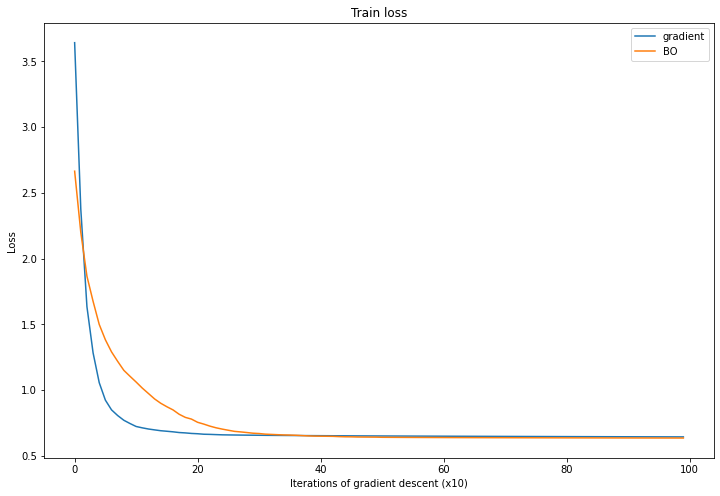

In [13]:
plt.plot(x, np.mean(plot_grad_train, axis=0), label='gradient')
plt.plot(x, np.mean(plot_bo_train, axis=0), label='BO')
plt.xlabel('Iterations of gradient descent (x10)')
plt.ylabel('Loss')
plt.title('Train loss')
plt.legend()
plt.show()

### Test loss

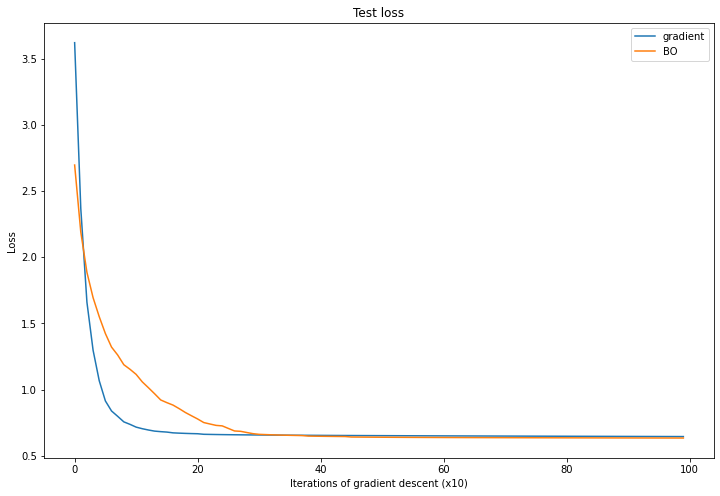

In [14]:
plt.plot(x, np.mean(plot_grad_test, axis=0), label='gradient')
plt.plot(x, np.mean(plot_bo_test, axis=0), label='BO')
plt.xlabel('Iterations of gradient descent (x10)')
plt.ylabel('Loss')
plt.title('Test loss')
plt.legend()
plt.show()

### Results

In [15]:
final_grad = np.mean(plot_grad_test, axis=0)[-1]
final_bo = np.mean(plot_bo_test, axis=0)[-1]

In [16]:
# Difference in loss for GD only and bayesian optimization

print("Mean final loss :", final_grad, "(gradient descent only)")
print("Mean final loss :", final_bo, "(bayesian optimization)")
print("Difference :", round((final_grad - final_bo) / final_bo * 100, 2), "%")

Mean final loss : 0.6446581512689591 (gradient descent only)
Mean final loss : 0.6335808688402176 (bayesian optimization)
Difference : 1.75 %


In [17]:
# Access all the last loss values for each instance

last_grad_test = [element[-1] for element in plot_grad_test]
last_bo_test = [element[-1] for element in plot_bo_test]

In [18]:
# Check the statistical significance of the difference in final loss

print("p-value =", ttest_ind(last_grad_test, last_bo_test)[1])

p-value = 0.02822110460414481


We see that the results for Bayesian optimization show a decrease in the loss. However, we want to make sure that this decrease is actually due to the bayesian optimization, and not simply the random search aspect. So we now compare bayesian optimization to gradient descent with 15 initial random searches.

## With random search

In [19]:
rand_grad_train_loss = []
rand_grad_test_loss = []

# Bayesian optimization will search in [-bound, +bound]
bound = 1/np.sqrt(3)
pbar = tqdm(total=n_inst)

for i in range(n_inst):
    
    torch.manual_seed(i)
    # Separate train and test set
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20)
    X_train = torch.from_numpy(X_train.to_numpy()).float()
    y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
    X_test = torch.from_numpy(X_test.to_numpy()).float()
    y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

    # Initialize an instance of Bayesian Optimization to optimize the weights and biases of the net
    netBO = BayesianOptimization(net_classifier, {  'w100': (-bound, bound),
                                                    'w101': (-bound, bound),
                                                    'w102': (-bound, bound),
                                                    'w110': (-bound, bound),
                                                    'w111': (-bound, bound),
                                                    'w112': (-bound, bound),
                                                    'w120': (-bound, bound),
                                                    'w121': (-bound, bound),
                                                    'w122': (-bound, bound),
                                                    'b10': (-bound, bound),
                                                    'b11': (-bound, bound),
                                                    'b12': (-bound, bound),
                                                    'w20': (-bound, bound),
                                                    'w21': (-bound, bound),
                                                    'w22': (-bound, bound),
                                                    'b2': (-bound, bound)},
                                                    verbose= 0,
                                                    random_state=i)
    
    # Maximize the negative loss
    netBO.maximize(n_iter=0, init_points=15)

    # Get the weights and biases that got the best result
    params = netBO.max['params']
    
    # Initialize a neural net
    net = Net(X.shape[1])
    
    # Initialize the weights with the best result from BO
    weights1 = torch.nn.Parameter(torch.Tensor(np.array([[params['w100'], params['w101'], params['w102']], [params['w110'], params['w111'], params['w112']], [params['w120'], params['w121'], params['w122']]])))
    bias1 = torch.nn.Parameter(torch.Tensor(np.array([params['b10'], params['b11'], params['b12']])))
    weights2 = torch.nn.Parameter(torch.Tensor(np.array([[params['w20'], params['w21'], params['w22']]])))
    bias2 = torch.nn.Parameter(torch.Tensor(np.array([params['b2']])))
    
    net.fc1.weight = weights1
    net.fc1.bias = bias1
    net.fc2.weight = weights2
    net.fc2.bias = bias2

    criterion = nn.BCELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001)

    # Gradient descent on the net with the weights and biases set by BO
    train_loss, test_loss = grad_descent(n_steps, net, optimizer, criterion, X_train, y_train, X_test, y_test)

    rand_grad_train_loss.append(train_loss)
    rand_grad_test_loss.append(test_loss)

    pbar.update(1)

pbar.close()
    

100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


In [20]:
plot_rand_grad_test = []
plot_rand_grad_train = []

for element in rand_grad_test_loss:
    inter = []
    for sub in element:
        inter.append(sub.detach().numpy().tolist())
    plot_rand_grad_test.append(inter)

for element in rand_grad_train_loss:
    inter = []
    for sub in element:
        inter.append(sub.detach().numpy().tolist())
    plot_rand_grad_train.append(inter)

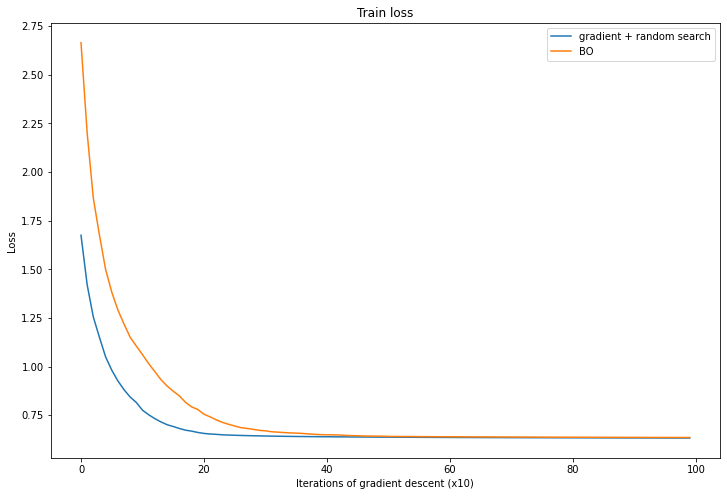

In [21]:
plt.plot(x, np.mean(plot_rand_grad_train, axis=0), label='gradient + random search')
plt.plot(x, np.mean(plot_bo_train, axis=0), label='BO')
plt.xlabel('Iterations of gradient descent (x10)')
plt.ylabel('Loss')
plt.title('Train loss')
plt.legend()
plt.show()

In [22]:
final_rand_grad = np.mean(plot_rand_grad_test, axis=0)[-1]
final_bo = np.mean(plot_bo_test, axis=0)[-1]

In [23]:
# Difference in loss for GD + random search and bayesian optimization

print("Mean final loss :", final_rand_grad, "(gradient descent + random search)")
print("Mean final loss :", final_bo, "(bayesian optimization)")
print("Difference :", round((final_rand_grad - final_bo) / final_bo * 100, 2), "%")

Mean final loss : 0.6338917207717896 (gradient descent + random search)
Mean final loss : 0.6335808688402176 (bayesian optimization)
Difference : 0.05 %


In [24]:
# Access all the last loss values for each instance

last_rand_grad_test = [element[-1] for element in plot_rand_grad_test]
last_bo_test = [element[-1] for element in plot_bo_test]

In [25]:
# Check the statistical significance of the difference in final loss

print("p-value =", ttest_ind(last_rand_grad_test, last_bo_test)[1])

p-value = 0.9442880806789815


The results show that there is no statistical significance to the difference in final loss when accounting for random search prior to gradient descent. Knowing that bayesian optimization is very time-consuming, it's fair to say that for this case, bayesian optimization is not particularly well adapted.